In [1]:
# Import the relevant libraries 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)
# Import the relevant libraries 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 

In [28]:
df = pd.read_csv('../data/CDC/truth-Incident Hospitalizations.csv',index_col='date')
df.index = pd.to_datetime(df.index)
df = df[df.index > '2020-10-10'] # Cut down the data before 2020-10-10
df.head()
df_state = df[df['location_name'] == 'Arizona']

(119, 3) (2, 3)


/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_32590/3034772440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state_train['value'] = df_state_train['value'].apply(lambda x: x+1 if x==0 else x) # Add 1 to all 0 values


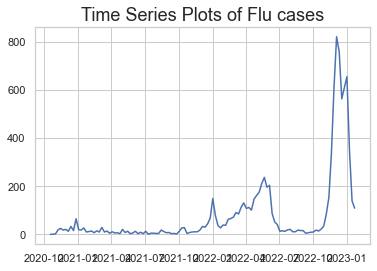

In [29]:
df_state_train = df_state.iloc[:-2, :] # Train set  
df_state_test = df_state.iloc[-2:, :] # Test set for validation
print(df_state_train.shape, df_state_test.shape)

fig, ax = plt.subplots()
ax.plot(df_state_train.index, df_state_train['value'])
ax.set_title('Time Series Plots of Flu cases', size=18)
df_state_train['value'] = df_state_train['value'].apply(lambda x: x+1 if x==0 else x) # Add 1 to all 0 values

Text(0.5, 0, 'Year')

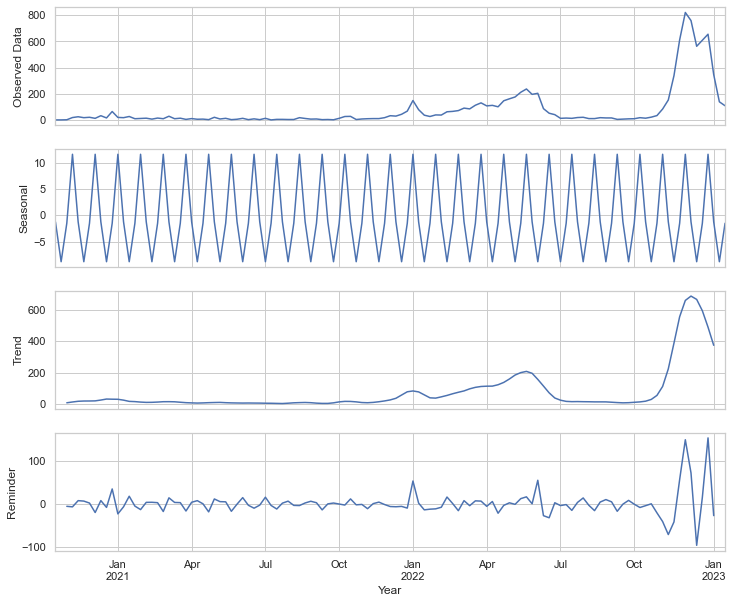

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_state_train['value'], model='addictive', period=4) # period = 12
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Year")

Text(0.5, 0, 'Year')

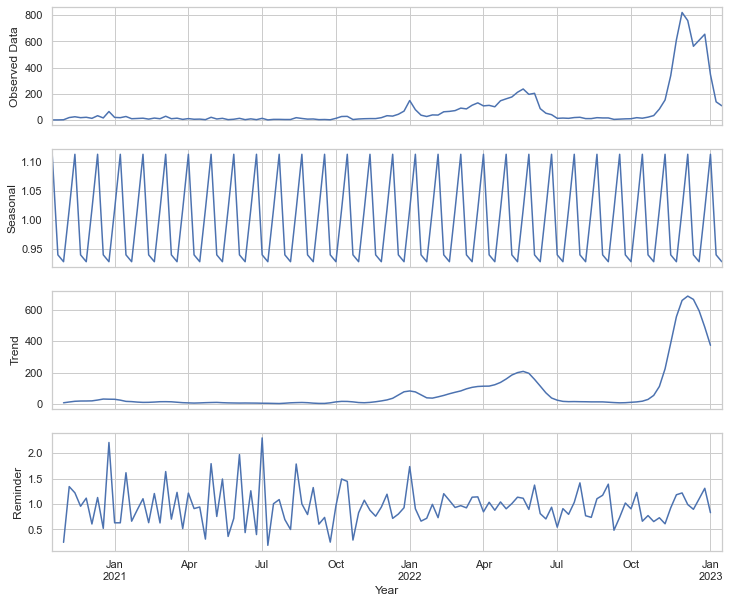

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_state_train['value'], model='mul', period=4) # period = 12
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Year")

In [32]:
# temp_df = df.copy()
# temp_df['value'] = temp_df['value'].apply(lambda x: x+1 if x==0 else x)
# from statsmodels.tsa.seasonal import seasonal_decompose
# final = seasonal_decompose(temp_df['value'],model='multiplicative',period=7)

In [33]:
df_state_test

,location,location_name,value
date,,,
2023-01-28,04,Arizona,48
2023-02-04,04,Arizona,56


In [50]:
train = pd.Series(df_state_train['value']).astype('float64')
ets_model = ETSModel(train, error='add', trend='add', seasonal = 'add', 
                     damped_trend=True, seasonal_periods=4, initial_level=train.values.mean(), freq = 'W-SAT')
ets_fitted = ets_model.fit()

# plt.figure(figsize=(10,8))
# train.plot(label='Original data')
# # ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
# plt.title('Visualisation of Flu Data and fitted Flu data by ETS Model' , fontsize=16)
# plt.ylabel("Flu cases");
# plt.xlabel("Year")
# plt.legend();
# ets_fitted.fittedvalues.plot()
fitted_summary = ets_fitted.get_prediction(start=df_state_train.index[-1]+ pd.Timedelta(1, unit='W'), end= df_state_train.index[-1] + pd.Timedelta(5, unit='W')).summary_frame(alpha=0.05)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.26153D+00    |proj g|=  8.99900D-01

At iterate    1    f=  5.48315D+00    |proj g|=  1.66466D-01

At iterate    2    f=  5.43678D+00    |proj g|=  9.75622D-02

At iterate    3    f=  5.43423D+00    |proj g|=  4.58643D-02

At iterate    4    f=  5.42780D+00    |proj g|=  5.10024D-02

At iterate    5    f=  5.42682D+00    |proj g|=  8.74934D-02

At iterate    6    f=  5.42163D+00    |proj g|=  8.35040D-02

At iterate    7    f=  5.41625D+00    |proj g|=  3.87948D-01

At iterate    8    f=  5.41243D+00    |proj g|=  5.48183D-02

At iterate    9    f=  5.41075D+00    |proj g|=  4.35048D-03

At iterate   10    f=  5.41074D+00    |proj g|=  3.07550D-03

At iterate   11    f=  5.41074D+00    |proj g|=  1.06430D-03

At iterate   12    f=  5.41074D+00    |proj g|=  1.06244D-03

At iterate   13    f=  5.4

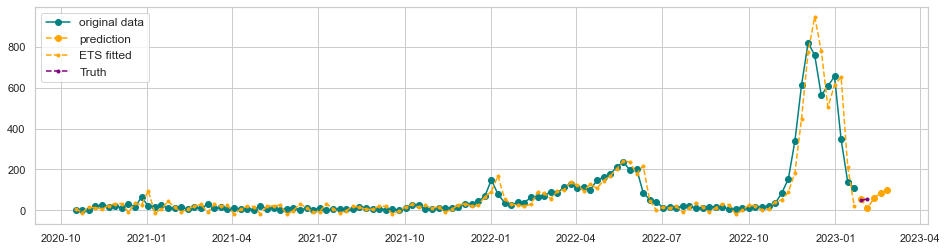

In [51]:
abs(fitted_summary['mean'])
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(train, '-o', label="original data", color='teal')
plt.plot(abs(fitted_summary['mean']), '--o', label='prediction', color='orange')
plt.plot(ets_fitted.fittedvalues, '--.', label='ETS fitted', color='orange')
plt.plot(df_state_test['value'], '--.', label='Truth', color='Purple')
plt.legend(fontsize=12)

In [54]:
# ets_fitted.get_prediction(start=df_state_train.index[-3]+ pd.Timedelta(1, unit='W'), end= df_state_train.index[-1] + pd.Timedelta(7, unit='W')).summary_frame(alpha=0.05)

In [52]:
fitted_summary

,mean,pi_lower,pi_upper
2023-01-28,56.675584,-46.744255,160.095423
2023-02-04,-8.728071,-189.021660,171.565519
2023-02-11,-60.957779,-317.924133,196.008575
2023-02-18,-84.497873,-417.269134,248.273388
2023-02-25,-98.122689,-504.996029,308.750652


In [10]:
pred_ets= ets_fitted.fittedvalues # Store the predicted values based on ETS model as "pred_ets"

In [11]:
expected_ets = train.values
predicted_ets = pred_ets.values

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    errors_mean = np.abs(testing_series - prediction_series ).mean()
    d = np.abs(running_diff(training_series, 12) ).mean()
    return errors_mean/d

mse_ets  = mean_squared_error(expected_ets, predicted_ets)
rmse_ets = sqrt(mse_ets)
mae_ets  = mean_absolute_error(expected_ets, predicted_ets)
mpe_ets  = mean_percentage_error(expected_ets, predicted_ets)
mape_ets = mean_absolute_percentage_error(expected_ets, predicted_ets)
mase_ets = mean_absolute_scaled_error(expected_ets, expected_ets, predicted_ets)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.2f' % rmse_ets)
print('- MAE : %.2f' % mae_ets)
print('- MPE : %.2f' % mpe_ets)
print('- MAPE: %.2f' % mape_ets)
print('- MASE: %.2f' % mase_ets)

In-Sample Error Measures of ETS Models:

- RMSE: 70.94
- MAE : 32.83
- MPE : -30.70
- MAPE: 48.47
- MASE: 0.22


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.69270D+00    |proj g|=  9.26059D-01

At iterate    1    f=  5.23200D+00    |proj g|=  7.43640D-01

At iterate    2    f=  4.95266D+00    |proj g|=  5.30436D-01

At iterate    3    f=  4.87230D+00    |proj g|=  1.92778D-01

At iterate    4    f=  4.85251D+00    |proj g|=  3.90317D-01

At iterate    5    f=  4.83470D+00    |proj g|=  1.76084D-01

At iterate    6    f=  4.81847D+00    |proj g|=  2.34491D-01

At iterate    7    f=  4.80440D+00    |proj g|=  2.39148D-01

At iterate    8    f=  4.80434D+00    |proj g|=  2.71069D-01

At iterate    9    f=  4.80434D+00    |proj g|=  2.74310D-01

At iterate   10    f=  4.80432D+00    |proj g|=  2.80875D-01

At iterate   11    f=  4.80422D+00    |proj g|=  2.95928D-01

At iterate   12    f=  4.80037D+00    |proj g|=  3.28083D-01

At iterate   13    f=  4.7

2023-01-07    1128.238746
2023-01-14    1092.913384
2023-01-21     780.765722
2023-01-28     535.674128
2023-02-04     336.786716
Freq: W-SAT, dtype: float64

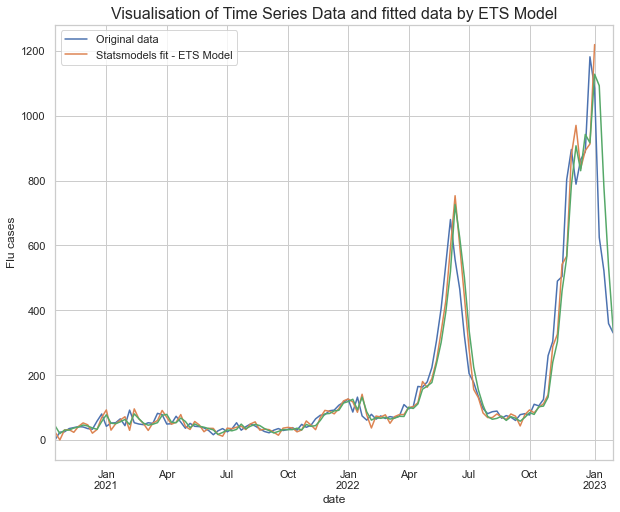

In [167]:
# ETS Model for Validation 
flu_data = pd.Series(df_state['value']).astype('float64')
ets_model_holdout = ETSModel(flu_data, error='mul', trend='add', seasonal = 'mul', 
                             damped_trend=True, seasonal_periods=4, freq = 'W-SAT',initial_level=train.values.mean())
ets_fitted_holdout = ets_model_holdout.fit()
plt.figure(figsize=(10,8))
flu_data.plot(label='Original data')
ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Flu cases");
plt.xlabel("Year")
plt.legend();
ets_fitted_holdout.fittedvalues.plot()
ets_fitted_holdout.predict()[-5:]
# ets_fitted_holdout.get_prediction(start=df_state.index[-1]+ pd.Timedelta(1, unit='W'), end= df_state.index[-1] + pd.Timedelta(4, unit='W')).summary_frame(alpha=0.05)

In [ ]:
# simulated = ets_fitted.simulate(anchor="end", nsimulations=17, repetitions=100)
# for i in range(simulated.shape[1]):
#     simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.1)
# pred_df["mean"].plot(label="mean prediction")
# pred_df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
# pred_df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
# pred.endog.plot(label="data")
# plt.legend()

In [146]:
def ets_model(state_name, df):
    state_df = df[df['location_name'] == state_name]
    ets_model = ETSModel(pd.Series(state_df['value']).astype('float64'), error='add', trend='add', seasonal = 'add', 
                     damped_trend=True, seasonal_periods=4, initial_level=state_df.value.mean())
    ets_fitted = ets_model.fit()
    plt.figure(figsize=(10,8))
    pd.Series(state_df['value']).astype('float64').plot(label= 'Original data')
    ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
    plt.title(state_name + ' Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
    plt.ylabel("Flu cases");
    plt.xlabel("Year")
    plt.legend();
    pred = ets_fitted.get_prediction(start=state_df.index[-1]+ pd.Timedelta(1, unit='W'), end=state_df.index[-1] + pd.Timedelta(4, unit='W'))
    pred_df = pred.summary_frame(alpha=0.05)
    pred_df['location_name'] = state_name
    return pred_df

In [147]:
df = pd.read_csv('/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv',index_col='date')
df.index = pd.to_datetime(df.index)
df = df[(df.index > '2020-01-01') & (df.index < '2023-1-31')] # Cut down the data before 2020-10-10
df['value'] = df['value'].apply(lambda x: x+1 if x==0 else x)

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.27256D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.55591D+00    |proj g|=  3.22934D-02

At iterate    2    f=  4.55553D+00    |proj g|=  2.44478D-02

At iterate    3    f=  4.55499D+00    |proj g|=  5.74820D-03

At iterate    4    f=  4.55495D+00    |proj g|=  5.73142D-03

At iterate    5    f=  4.55457D+00    |proj g|=  1.02339D-02

At iterate    6    f=  4.55384D+00    |proj g|=  2.38661D-02

At iterate    7    f=  4.55135D+00    |proj g|=  3.69412D-02

At iterate    8    f=  4.54082D+00    |proj g|=  4.86427D-02

At iterate    9    f=  4.53734D+00    |proj g|=  2.40471D-02

At iterate   10    f=  4.53696D+00    |proj g|=  8.22169D-03

At iterate   11    f=  4.53688D+00    |proj g|=  1.35065D-03

At iterate   12    f=  4.53686D+00    |proj g|=  1.47331D-03

At iterate   13    f=  4.5

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.08877D+00    |proj g|=  8.99900D-01

At iterate    1    f=  5.23617D+00    |proj g|=  2.94422D-01

At iterate    2    f=  5.10213D+00    |proj g|=  1.03163D-01

At iterate    3    f=  5.07916D+00    |proj g|=  4.35117D-02

At iterate    4    f=  5.07693D+00    |proj g|=  3.89191D-03

At iterate    5    f=  5.06905D+00    |proj g|=  2.53317D-03

At iterate    6    f=  5.06117D+00    |proj g|=  2.11413D-03

At iterate    7    f=  5.06040D+00    |proj g|=  1.76019D-03

At iterate    8    f=  5.05911D+00    |proj g|=  8.17213D-04

At iterate    9    f=  5.05860D+00    |proj g|=  2.31903D-04

At iterate   10    f=  5.05856D+00    |proj g|=  1.66356D-04

At iterate   11    f=  5.05853D+00    |proj g|=  1.06315D-04

At iterate   12    f=  5.05848D+00    |proj g|=  1.87406D-05

At iterate   13    f=  5.0

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.70727D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.90855D+00    |proj g|=  1.66042D-01

At iterate    2    f=  4.89890D+00    |proj g|=  1.30119D-01

At iterate    3    f=  4.88974D+00    |proj g|=  4.60509D-02

At iterate    4    f=  4.88818D+00    |proj g|=  8.16396D-03

At iterate    5    f=  4.88811D+00    |proj g|=  4.50022D-03

At iterate    6    f=  4.88801D+00    |proj g|=  5.14042D-03

At iterate    7    f=  4.88742D+00    |proj g|=  1.88496D-02

At iterate    8    f=  4.87806D+00    |proj g|=  4.50626D-02

At iterate    9    f=  4.87399D+00    |proj g|=  1.21292D-01

At iterate   10    f=  4.86431D+00    |proj g|=  1.44458D-02

At iterate   11    f=  4.86395D+00    |proj g|=  1.41576D-03

At iterate   12    f=  4.86392D+00    |proj g|=  1.37703D-03

At iterate   13    f=  4.8

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.02992D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.27995D+00    |proj g|=  1.45482D-01

At iterate    2    f=  4.24542D+00    |proj g|=  1.02714D-02

At iterate    3    f=  4.24524D+00    |proj g|=  9.75486D-03

At iterate    4    f=  4.24480D+00    |proj g|=  9.52598D-03

At iterate    5    f=  4.24196D+00    |proj g|=  3.16096D-02

At iterate    6    f=  4.23660D+00    |proj g|=  5.35363D-02

At iterate    7    f=  4.22964D+00    |proj g|=  5.01027D-02

At iterate    8    f=  4.22711D+00    |proj g|=  2.23329D-02

At iterate    9    f=  4.22654D+00    |proj g|=  6.34470D-03

At iterate   10    f=  4.22644D+00    |proj g|=  2.32347D-03

At iterate   11    f=  4.22639D+00    |proj g|=  3.63443D-03

At iterate   12    f=  4.22624D+00    |proj g|=  6.66001D-03

At iterate   13    f=  4.2

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  7.36779D+00    |proj g|=  4.31275D-01

At iterate    1    f=  6.86837D+00    |proj g|=  4.68625D-01
  ys=-6.481E-02  -gs= 3.135E-01 BFGS update SKIPPED

At iterate    2    f=  6.49095D+00    |proj g|=  2.54792D-01

At iterate    3    f=  6.43485D+00    |proj g|=  1.72638D-01

At iterate    4    f=  6.34378D+00    |proj g|=  1.07709D-03

At iterate    5    f=  6.33439D+00    |proj g|=  6.80078D-04

At iterate    6    f=  6.32831D+00    |proj g|=  7.83284D-04

At iterate    7    f=  6.32829D+00    |proj g|=  7.77955D-04

At iterate    8    f=  6.32828D+00    |proj g|=  7.75202D-04

At iterate    9    f=  6.32825D+00    |proj g|=  7.68807D-04

At iterate   10    f=  6.32819D+00    |proj g|=  7.54863D-04

At iterate   11    f=  6.32802D+00    |proj g|=  7.21556D-04

At iterate   12    f=  6.32761D+00  

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.99620D+00    |proj g|=  4.56543D-01

At iterate    1    f=  5.50121D+00    |proj g|=  4.43357D-01
  ys=-2.690E-02  -gs= 3.550E-01 BFGS update SKIPPED

At iterate    2    f=  5.17247D+00    |proj g|=  2.19950D-01

At iterate    3    f=  5.01270D+00    |proj g|=  4.29479D-03

At iterate    4    f=  5.00297D+00    |proj g|=  2.55103D-03

At iterate    5    f=  4.99490D+00    |proj g|=  2.15366D-03

At iterate    6    f=  4.99361D+00    |proj g|=  1.48255D-03

At iterate    7    f=  4.99255D+00    |proj g|=  1.82965D-04

At iterate    8    f=  4.99254D+00    |proj g|=  1.33493D-04

At iterate    9    f=  4.99247D+00    |proj g|=  1.67244D-04

At iterate   10    f=  4.99243D+00    |proj g|=  6.25278D-05

At iterate   11    f=  4.99243D+00    |proj g|=  2.20268D-05

At iterate   12    f=  4.99243D+00  

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.70576D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.96994D+00    |proj g|=  1.84002D-01

At iterate    2    f=  3.87130D+00    |proj g|=  9.31828D-03

At iterate    3    f=  3.87097D+00    |proj g|=  5.90265D-02

At iterate    4    f=  3.87042D+00    |proj g|=  9.38374D-03

At iterate    5    f=  3.87037D+00    |proj g|=  9.30709D-03

At iterate    6    f=  3.87031D+00    |proj g|=  1.13047D-02

At iterate    7    f=  3.87009D+00    |proj g|=  2.90592D-02

At iterate    8    f=  3.86972D+00    |proj g|=  4.54561D-02

At iterate    9    f=  3.86913D+00    |proj g|=  5.11300D-02

At iterate   10    f=  3.86379D+00    |proj g|=  1.86712D-02

At iterate   11    f=  3.86354D+00    |proj g|=  2.53106D-02

At iterate   12    f=  3.86319D+00    |proj g|=  3.20009D-02

At iterate   13    f=  3.8

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_39131/3976956580.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq'


At iterate   25    f=  4.15966D+00    |proj g|=  1.63345D-03

At iterate   26    f=  4.15962D+00    |proj g|=  1.44542D-03

At iterate   27    f=  4.15959D+00    |proj g|=  4.54925D-04

At iterate   28    f=  4.15958D+00    |proj g|=  7.15517D-04

At iterate   29    f=  4.15958D+00    |proj g|=  1.03562D-04

At iterate   30    f=  4.15957D+00    |proj g|=  4.92051D-05

At iterate   31    f=  4.15957D+00    |proj g|=  1.14486D-04

At iterate   32    f=  4.15957D+00    |proj g|=  3.37508D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     35     35     0     3   3.375D-06   4.160D+00
  F =   4.15957363324

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.49197D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.74752D+00    |proj g|=  1.11579D-01

At iterate    2    f=  3.73048D+00    |proj g|=  3.70953D-02

At iterate    3    f=  3.72936D+00    |proj g|=  1.15825D-01

At iterate    4    f=  3.72738D+00    |proj g|=  4.66914D-02

At iterate    5    f=  3.72666D+00    |proj g|=  1.48239D-02

At iterate    6    f=  3.72580D+00    |proj g|=  2.93976D-02

At iterate    7    f=  3.72418D+00    |proj g|=  6.09836D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    8    f=  3.72259D+00    |proj g|=  1.21824D-01

At iterate    9    f=  3.72185D+00    |proj g|=  1.58875D-01

At iterate   10    f=  3.71949D+00    |proj g|=  1.51538D-01

At iterate   11    f=  3.71610D+00    |proj g|=  1.50228D-02

At iterate   12 

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.18205D+00    |proj g|=  7.54815D-01

At iterate    1    f=  3.82600D+00    |proj g|=  1.01673D-01

At iterate    2    f=  3.81817D+00    |proj g|=  3.79540D-02

At iterate    3    f=  3.81729D+00    |proj g|=  4.34142D-03

At iterate    4    f=  3.81727D+00    |proj g|=  3.14659D-03

At iterate    5    f=  3.81726D+00    |proj g|=  3.14038D-03

At iterate    6    f=  3.81716D+00    |proj g|=  8.41611D-03

At iterate    7    f=  3.81698D+00    |proj g|=  1.57697D-02

At iterate    8    f=  3.81656D+00    |proj g|=  2.48603D-02

At iterate    9    f=  3.81596D+00    |proj g|=  2.83334D-02

At iterate   10    f=  3.81539D+00    |proj g|=  1.97000D-02

At iterate   11    f=  3.81517D+00    |proj g|=  5.45115D-03

At iterate   12    f=  3.81514D+00    |proj g|=  1.35394D-03

At iterate   13    f=  3.8

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.01558D+00    |proj g|=  5.17800D-01

At iterate    1    f=  5.46167D+00    |proj g|=  3.82100D-01
  ys=-6.116E-02  -gs= 3.680E-01 BFGS update SKIPPED

At iterate    2    f=  5.17990D+00    |proj g|=  2.26494D-01

At iterate    3    f=  5.14849D+00    |proj g|=  1.50427D-01

At iterate    4    f=  5.13362D+00    |proj g|=  2.55355D-01

At iterate    5    f=  5.12145D+00    |proj g|=  4.89326D-02

At iterate    6    f=  5.11772D+00    |proj g|=  9.82751D-02

At iterate    7    f=  5.11323D+00    |proj g|=  1.27985D-01

At iterate    8    f=  5.11164D+00    |proj g|=  6.69127D-03

At iterate    9    f=  5.11163D+00    |proj g|=  1.31282D-03

At iterate   10    f=  5.11163D+00    |proj g|=  1.50404D-03

At iterate   11    f=  5.11162D+00    |proj g|=  7.31619D-03

At iterate   12    f=  5.11158D+00  

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.60749D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.15548D+00    |proj g|=  8.78977D-02

At iterate    2    f=  3.15128D+00    |proj g|=  1.73860D-02

At iterate    3    f=  3.15097D+00    |proj g|=  1.24553D-02

At iterate    4    f=  3.15081D+00    |proj g|=  1.21875D-02

At iterate    5    f=  3.14956D+00    |proj g|=  3.08312D-02

At iterate    6    f=  3.14798D+00    |proj g|=  4.33619D-02

At iterate    7    f=  3.14610D+00    |proj g|=  3.48814D-02

At iterate    8    f=  3.14531D+00    |proj g|=  1.22403D-02

At iterate    9    f=  3.14513D+00    |proj g|=  3.70242D-03

At iterate   10    f=  3.14509D+00    |proj g|=  6.65126D-03

At iterate   11    f=  3.14501D+00    |proj g|=  1.09601D-02

At iterate   12    f=  3.14484D+00    |proj g|=  1.52879D-02

At iterate   13    f=  3.1

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia


At iterate   13    f=  4.67342D+00    |proj g|=  4.95071D-04

At iterate   14    f=  4.67342D+00    |proj g|=  6.17817D-04

At iterate   15    f=  4.67338D+00    |proj g|=  1.12781D-03

At iterate   16    f=  4.67335D+00    |proj g|=  1.24700D-03

At iterate   17    f=  4.67332D+00    |proj g|=  7.79021D-04

At iterate   18    f=  4.67331D+00    |proj g|=  2.26485D-04

At iterate   19    f=  4.67331D+00    |proj g|=  1.42464D-04

At iterate   20    f=  4.67331D+00    |proj g|=  1.93268D-04

At iterate   21    f=  4.67331D+00    |proj g|=  3.13527D-04

At iterate   22    f=  4.67330D+00    |proj g|=  4.45333D-04

At iterate   23    f=  4.67329D+00    |proj g|=  4.73044D-04

At iterate   24    f=  4.67328D+00    |proj g|=  1.84830D-04

At iterate   25    f=  4.67327D+00    |proj g|=  2.17870D-04

At iterate   26    f=  4.67327D+00    |proj g|=  2.47011D-03

At iterate   27    f=  4.67326D+00    |proj g|=  1.23990D-04

At iterate   28    f=  4.67326D+00    |proj g|=  9.81437D-05

At iter

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.96145D+00    |proj g|=  8.78235D-01

At iterate    1    f=  4.29784D+00    |proj g|=  8.65953D-02

At iterate    2    f=  4.29135D+00    |proj g|=  6.62776D-02

At iterate    3    f=  4.28455D+00    |proj g|=  1.80280D-01

At iterate    4    f=  4.23336D+00    |proj g|=  1.29687D-01

At iterate    5    f=  4.23177D+00    |proj g|=  4.80956D-02

At iterate    6    f=  4.23154D+00    |proj g|=  6.51141D-03

At iterate    7    f=  4.23048D+00    |proj g|=  2.95963D-02

At iterate    8    f=  4.22498D+00    |proj g|=  1.14120D-01

At iterate    9    f=  4.22166D+00    |proj g|=  1.05265D-01

At iterate   10    f=  4.22021D+00    |proj g|=  3.62762D-02

At iterate   11    f=  4.22007D+00    |proj g|=  1.89031D-03

At iterate   12    f=  4.22007D+00    |proj g|=  1.39977D-04

At iterate   13    f=  4.2

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.72629D+00    |proj g|=  8.69624D-01

At iterate    1    f=  5.03679D+00    |proj g|=  6.57324D-02

At iterate    2    f=  5.02608D+00    |proj g|=  4.63311D-02

At iterate    3    f=  5.02407D+00    |proj g|=  1.83708D-02

At iterate    4    f=  5.02372D+00    |proj g|=  3.01332D-03

At iterate    5    f=  5.02370D+00    |proj g|=  3.00426D-03

At iterate    6    f=  5.02364D+00    |proj g|=  3.51408D-03

At iterate    7    f=  5.02348D+00    |proj g|=  9.46674D-03

At iterate    8    f=  5.02307D+00    |proj g|=  1.93615D-02

At iterate    9    f=  5.02203D+00    |proj g|=  3.37458D-02

At iterate   10    f=  5.01958D+00    |proj g|=  5.19686D-02

At iterate   11    f=  5.01495D+00    |proj g|=  6.69214D-02

At iterate   12    f=  5.00934D+00    |proj g|=  6.50882D-02

At iterate   13    f=  5.0

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.66654D+00    |proj g|=  8.93831D-01

At iterate    1    f=  3.00735D+00    |proj g|=  8.92901D-02

At iterate    2    f=  2.99508D+00    |proj g|=  1.26242D-01
  ys=-3.125E-03  -gs= 1.037E-02 BFGS update SKIPPED

At iterate    3    f=  2.96922D+00    |proj g|=  1.45305D-01

At iterate    4    f=  2.95972D+00    |proj g|=  1.27353D-02

At iterate    5    f=  2.95961D+00    |proj g|=  1.25228D-02

At iterate    6    f=  2.95889D+00    |proj g|=  1.18898D-02

At iterate    7    f=  2.95776D+00    |proj g|=  2.28065D-02

At iterate    8    f=  2.95592D+00    |proj g|=  2.65798D-02

At iterate    9    f=  2.95369D+00    |proj g|=  1.76813D-02

At iterate   10    f=  2.95142D+00    |proj g|=  1.14835D-02

At iterate   11    f=  2.95049D+00    |proj g|=  1.38265D-02

At iterate   12    f=  2.94979D+00  

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.42441D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.62025D+00    |proj g|=  1.19267D-01

At iterate    2    f=  4.60318D+00    |proj g|=  5.34639D-02

At iterate    3    f=  4.60162D+00    |proj g|=  3.18853D-02

At iterate    4    f=  4.60073D+00    |proj g|=  1.56808D-03

At iterate    5    f=  4.60073D+00    |proj g|=  1.56595D-03

At iterate    6    f=  4.60070D+00    |proj g|=  3.16147D-03

At iterate    7    f=  4.60065D+00    |proj g|=  6.75762D-03

At iterate    8    f=  4.60049D+00    |proj g|=  1.30777D-02

At iterate    9    f=  4.60015D+00    |proj g|=  2.13293D-02

At iterate   10    f=  4.59942D+00    |proj g|=  2.96865D-02

At iterate   11    f=  4.59836D+00    |proj g|=  2.98649D-02

At iterate   12    f=  4.59758D+00    |proj g|=  1.69695D-02

At iterate   13    f=  4.5

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xia

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.24271D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.53822D+00    |proj g|=  1.06955D-01

At iterate    2    f=  3.43440D+00    |proj g|=  2.25732D-02

At iterate    3    f=  3.43409D+00    |proj g|=  2.15805D-02

At iterate    4    f=  3.42943D+00    |proj g|=  1.81033D-02

At iterate    5    f=  3.42187D+00    |proj g|=  3.72542D-03

At iterate    6    f=  3.42156D+00    |proj g|=  4.35088D-03

At iterate    7    f=  3.42109D+00    |proj g|=  3.62359D-03

At iterate    8    f=  3.42083D+00    |proj g|=  1.82494D-03

At iterate    9    f=  3.42076D+00    |proj g|=  1.34119D-03

At iterate   10    f=  3.42071D+00    |proj g|=  9.06608D-04

At iterate   11    f=  3.42063D+00    |proj g|=  1.13545D-03

At iterate   12    f=  3.42060D+00    |proj g|=  7.56506D-04

At iterate   13    f=  3.4

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.18135D-01    |proj g|=  2.17558D-01

At iterate    1    f=  1.10204D-01    |proj g|=  4.50584D-01

At iterate    2    f=  9.59875D-02    |proj g|=  4.40652D-01

At iterate    3    f=  7.59092D-02    |proj g|=  1.76849D-01

At iterate    4    f=  7.25769D-02    |proj g|=  9.80717D-02

At iterate    5    f=  6.71586D-02    |proj g|=  1.39806D+00
  ys=-7.396E-03  -gs= 5.759E-03 BFGS update SKIPPED

At iterate    6    f=  6.57121D-02    |proj g|=  8.04471D-02

At iterate    7    f=  6.50823D-02    |proj g|=  1.03047D-01

At iterate    8    f=  6.48189D-02    |proj g|=  4.66580D-02

At iterate    9    f=  6.47097D-02    |proj g|=  2.63364D-02

At iterate   10    f=  6.42488D-02    |proj g|=  1.89815D-01

At iterate   11    f=  6.42118D-02    |proj g|=  9.07140D-02

At iterate   12    f=  6.42020D-02  

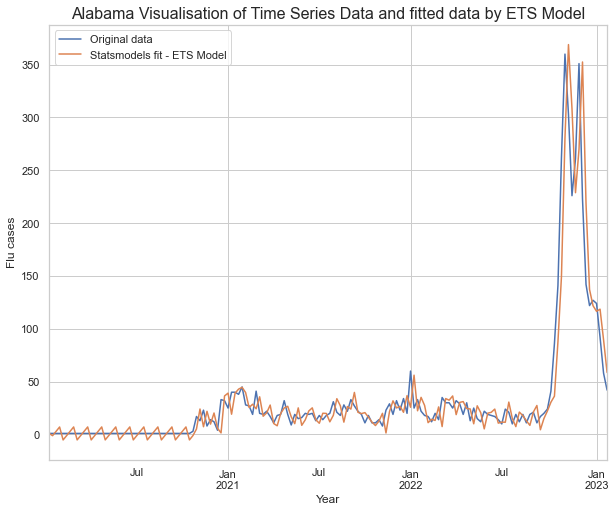

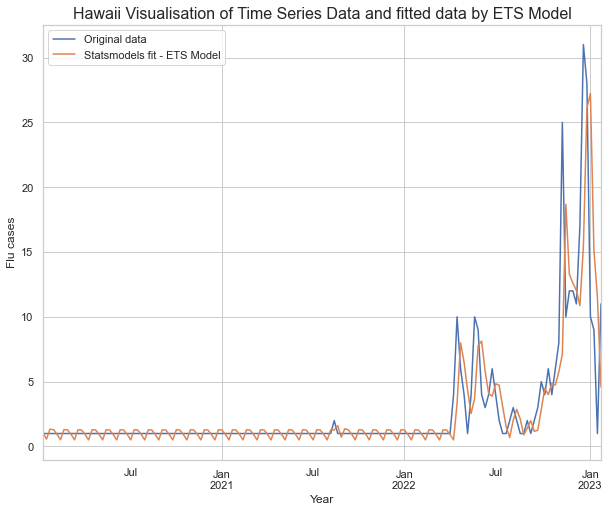

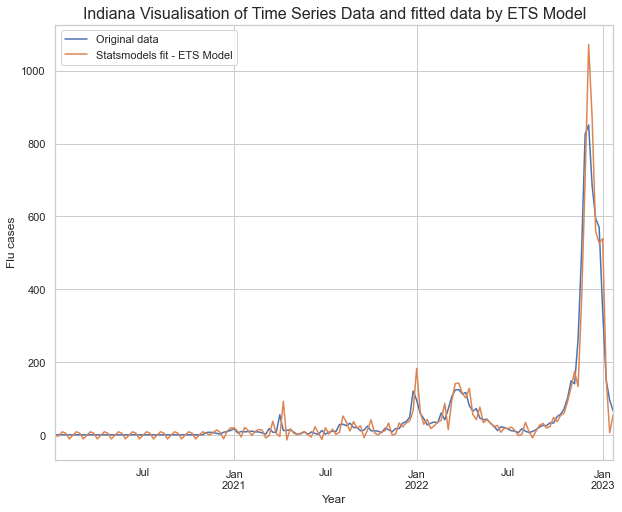

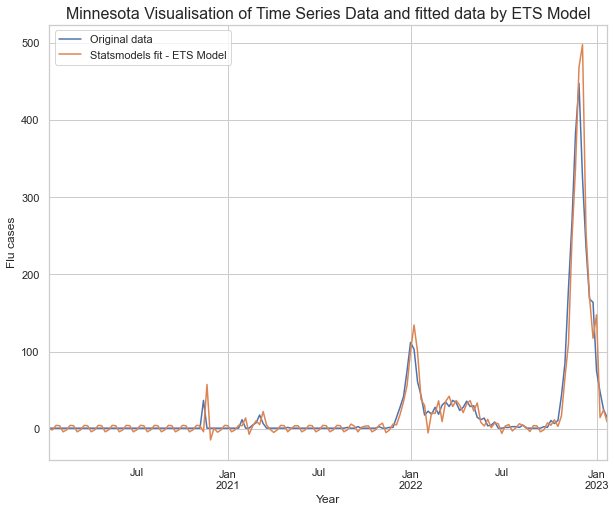

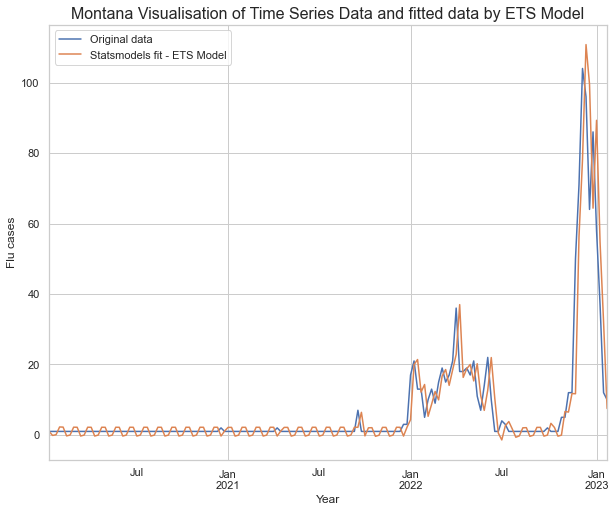

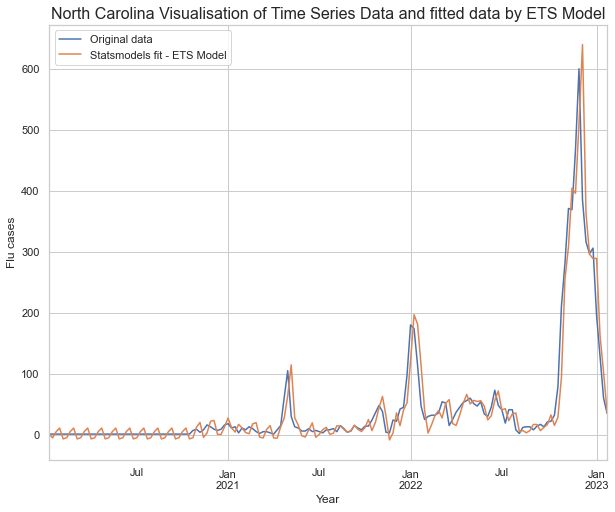

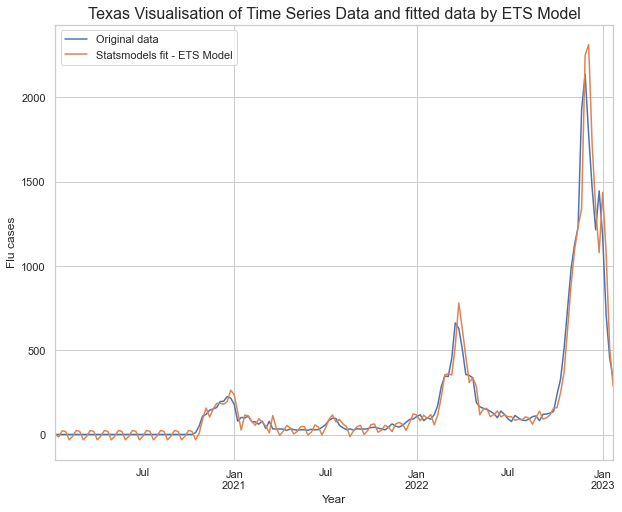

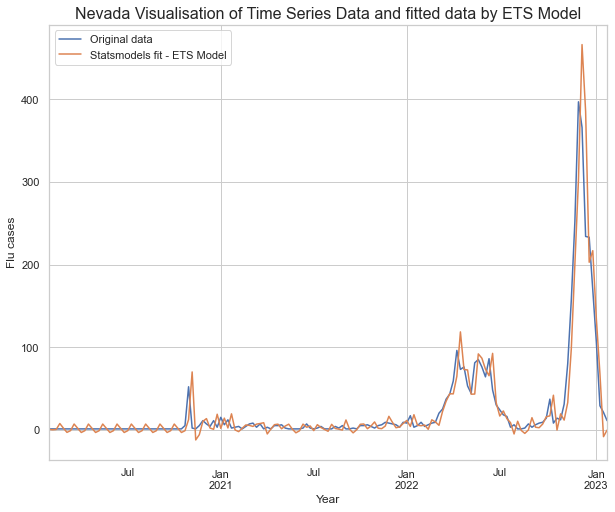

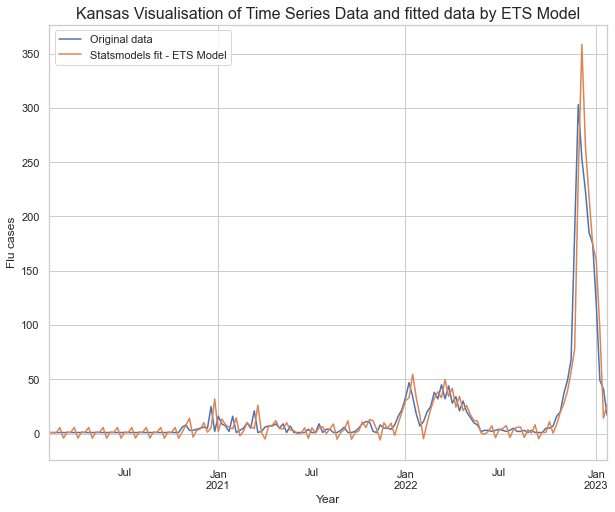

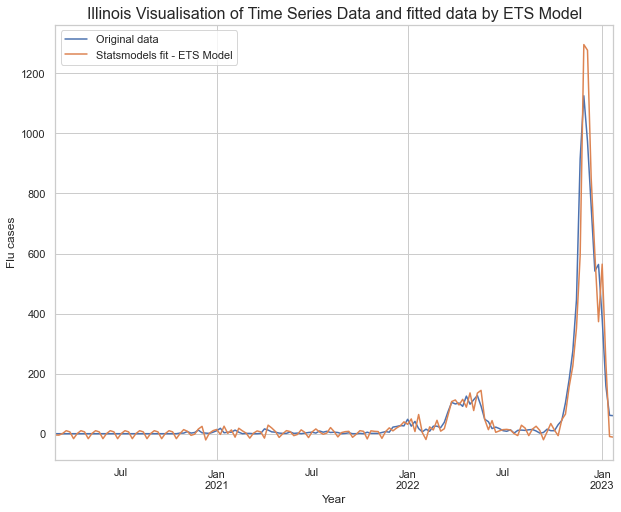

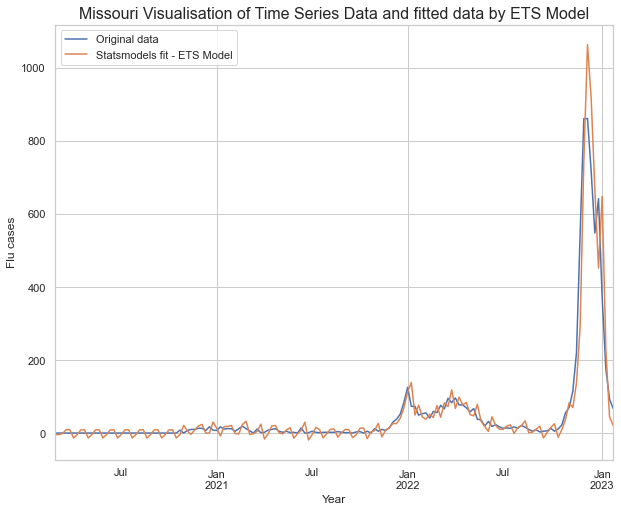

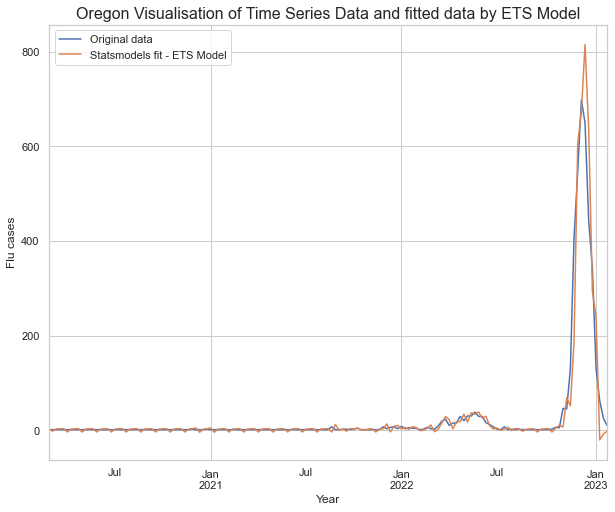

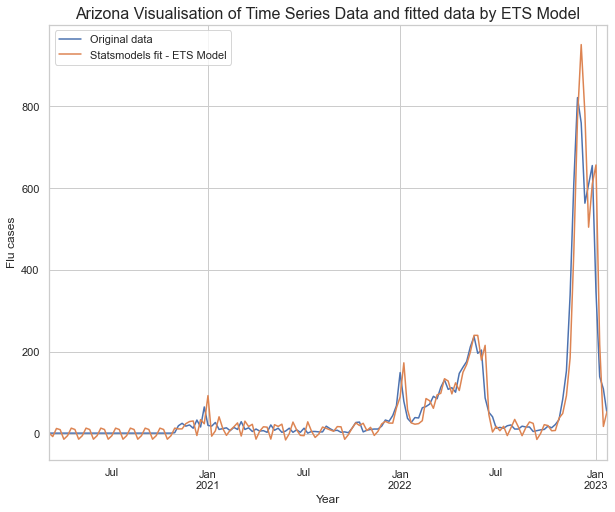

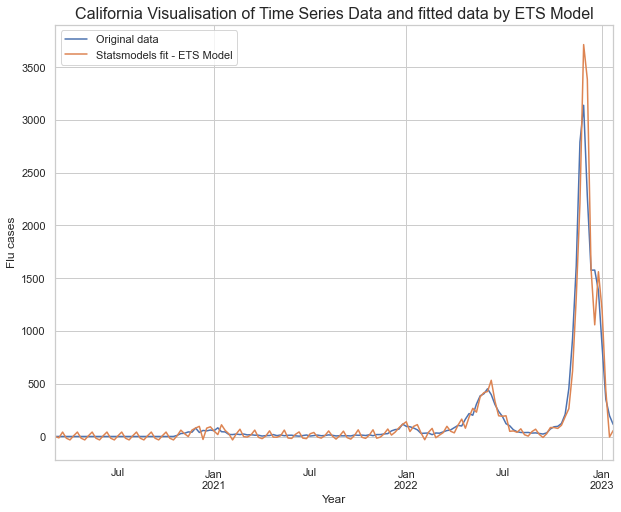

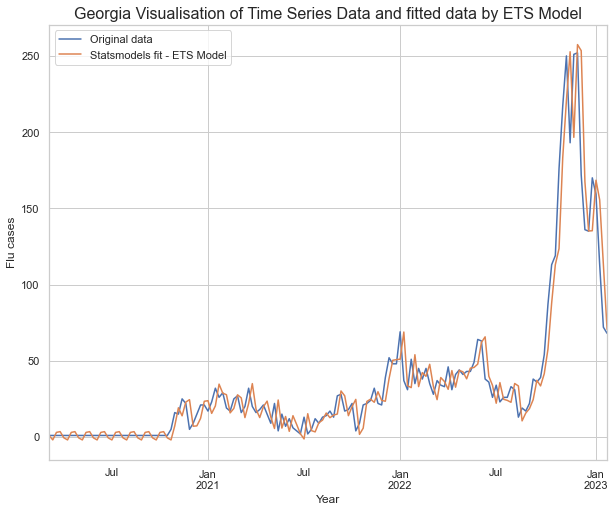

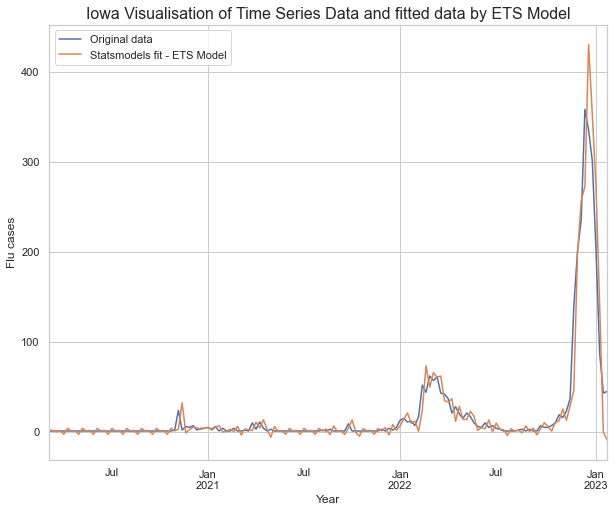

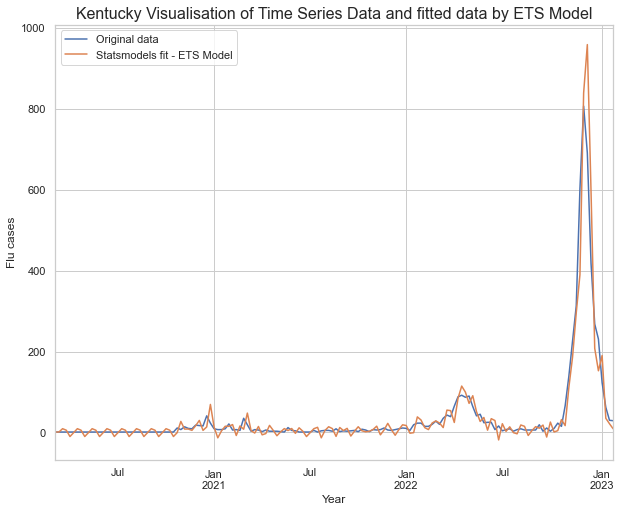

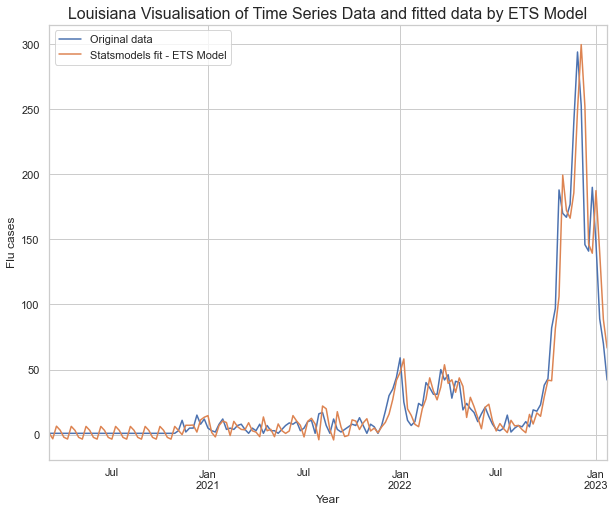

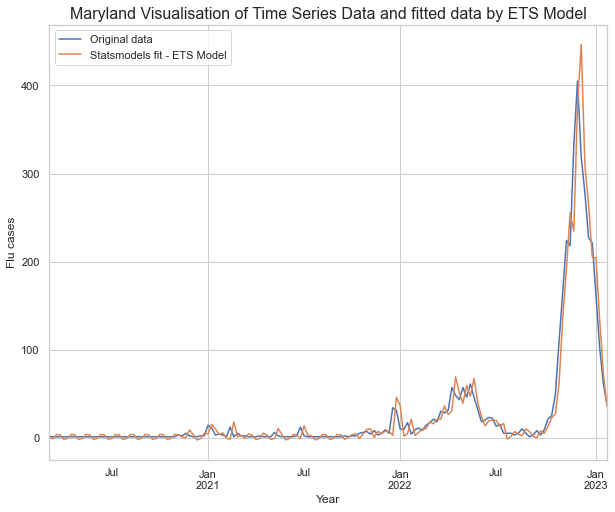

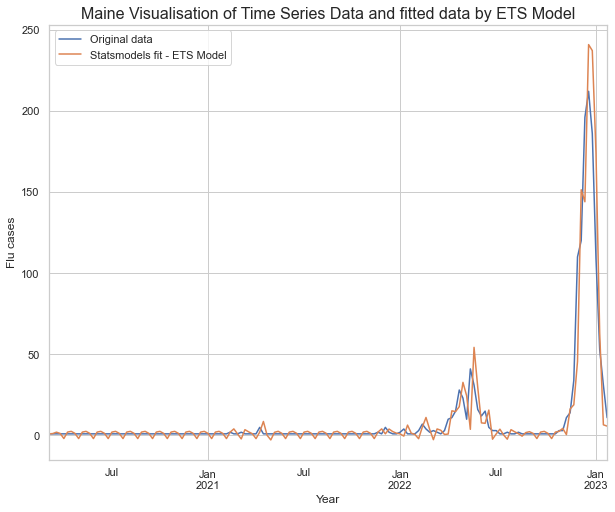

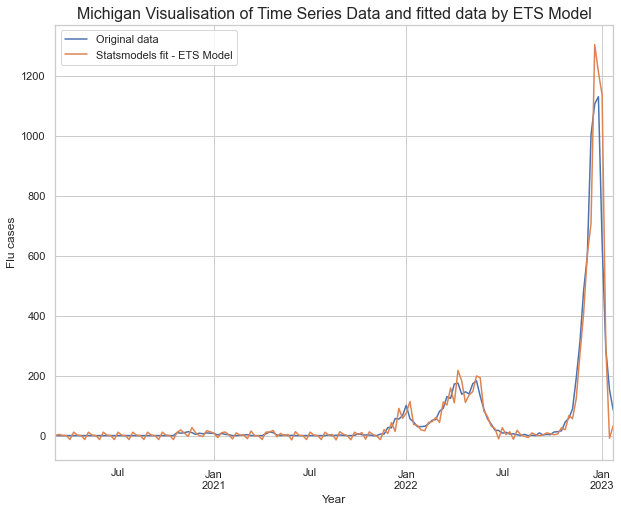

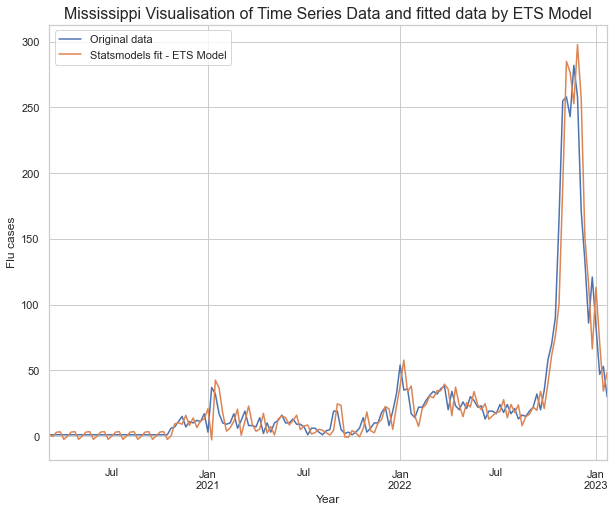

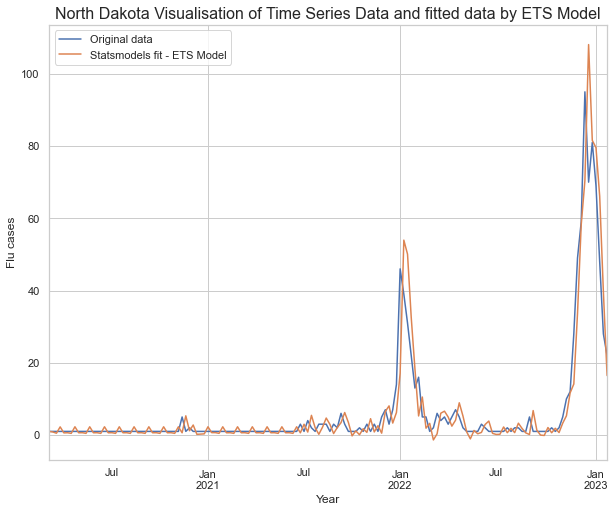

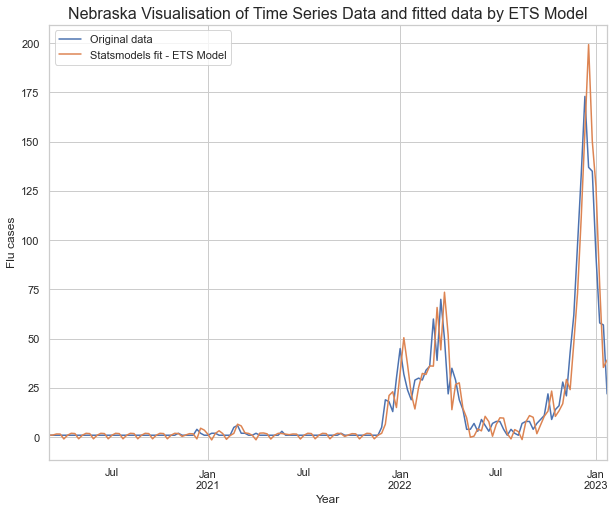

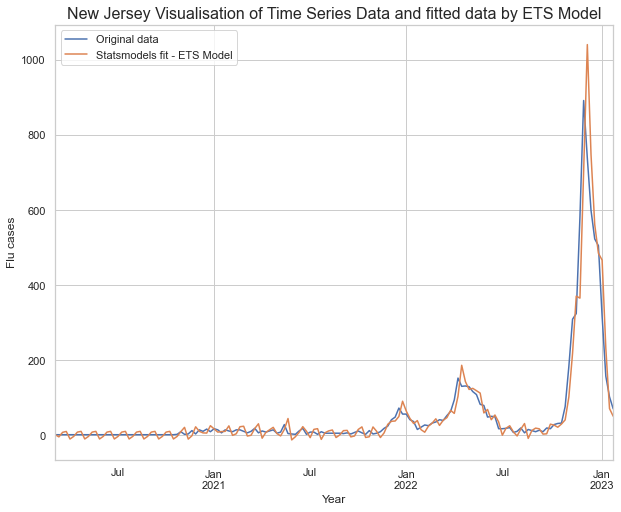

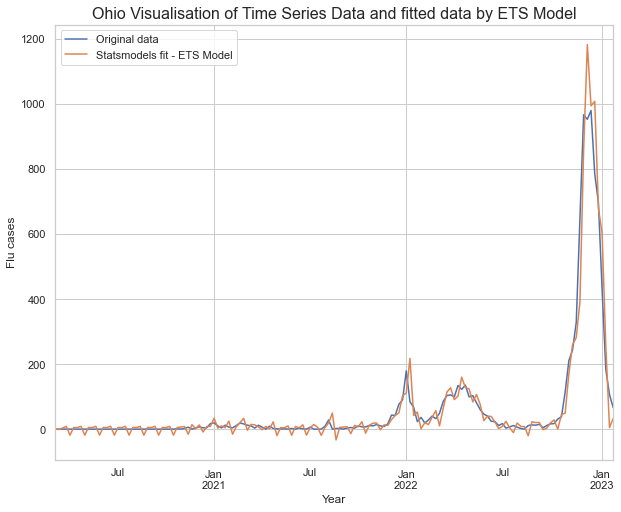

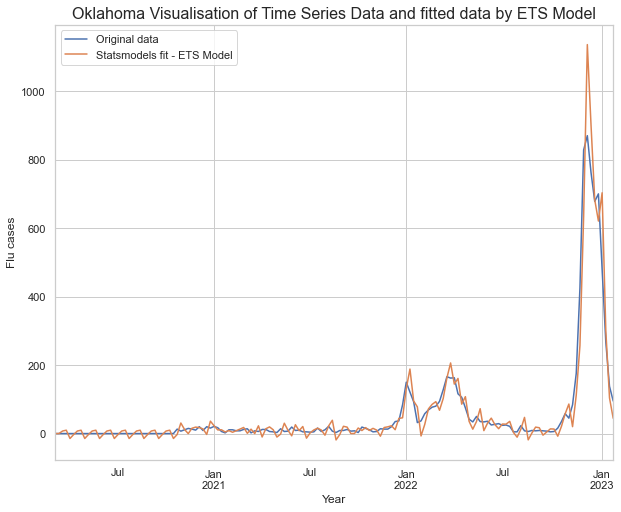

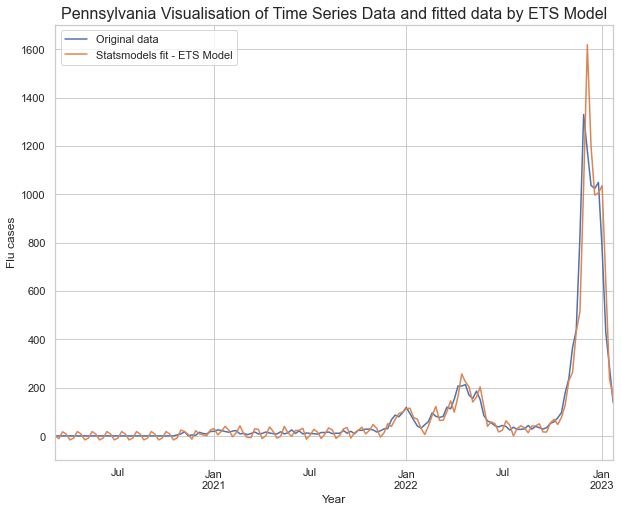

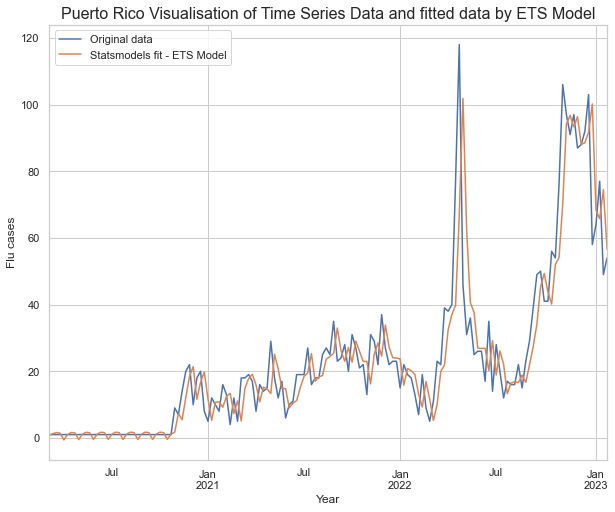

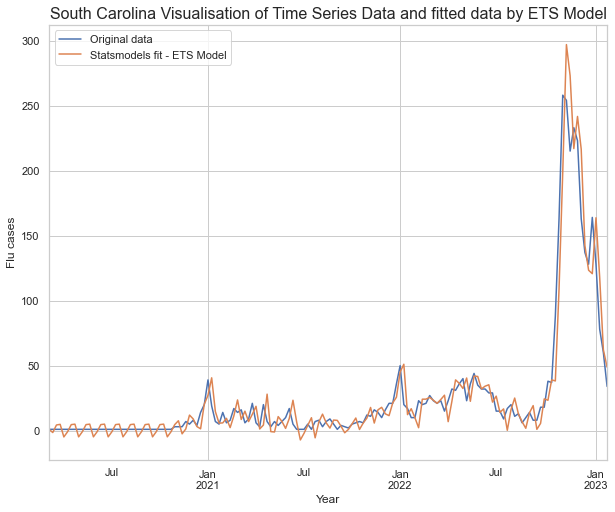

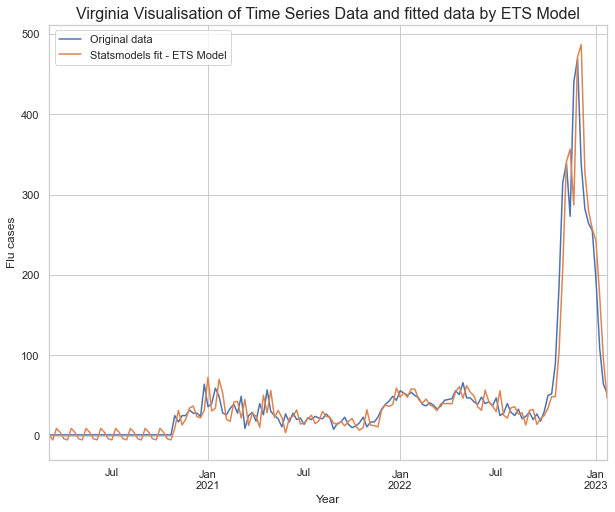

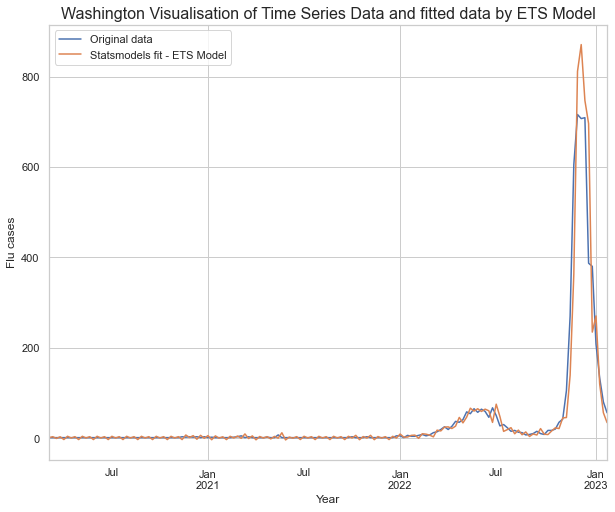

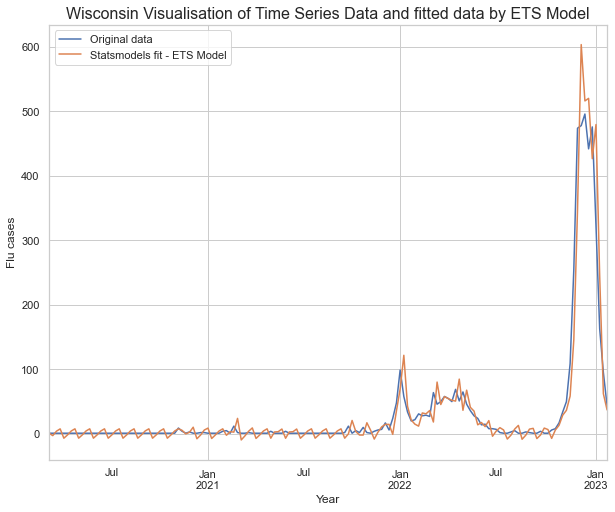

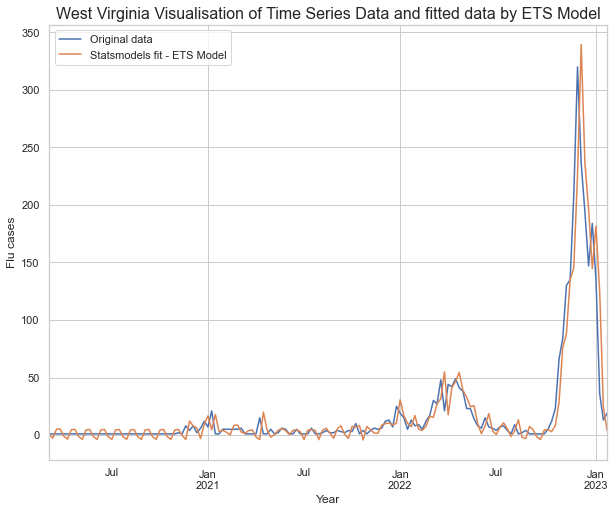

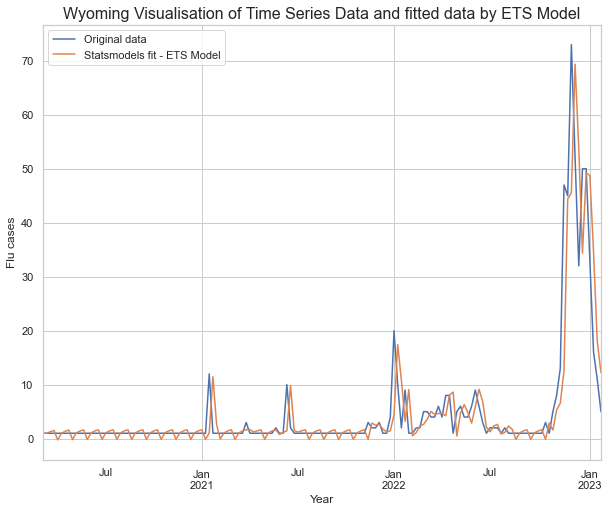

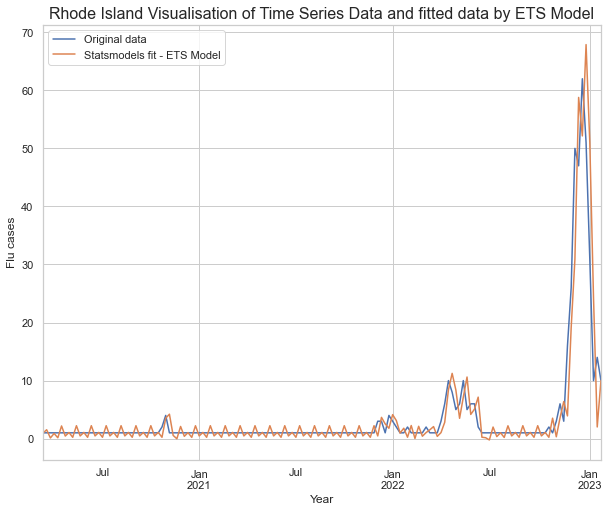

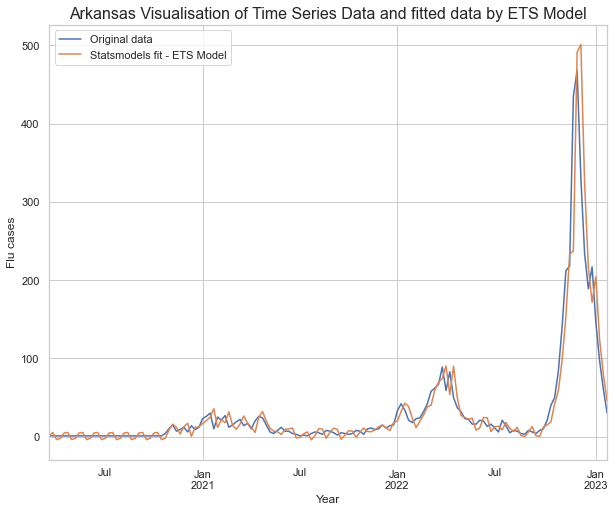

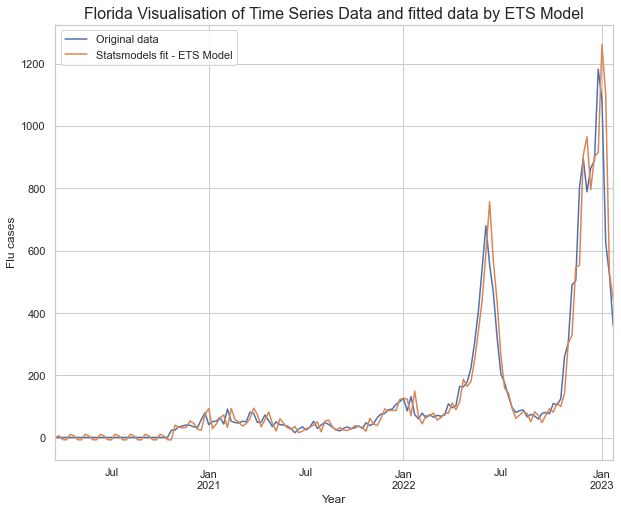

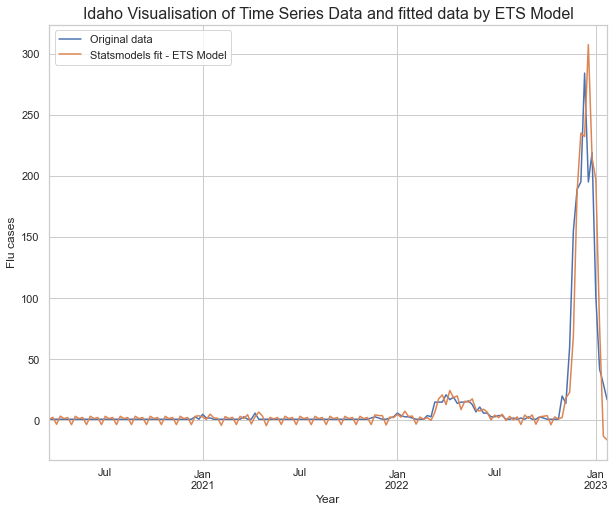

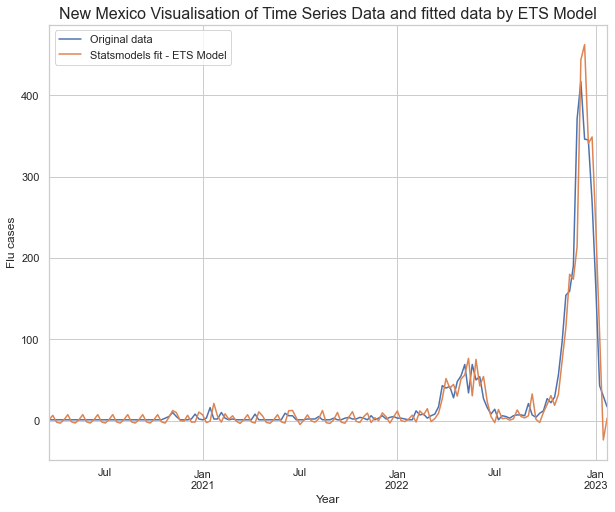

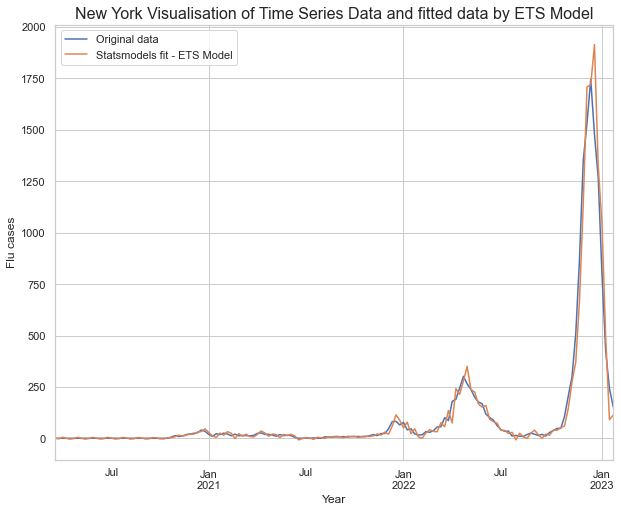

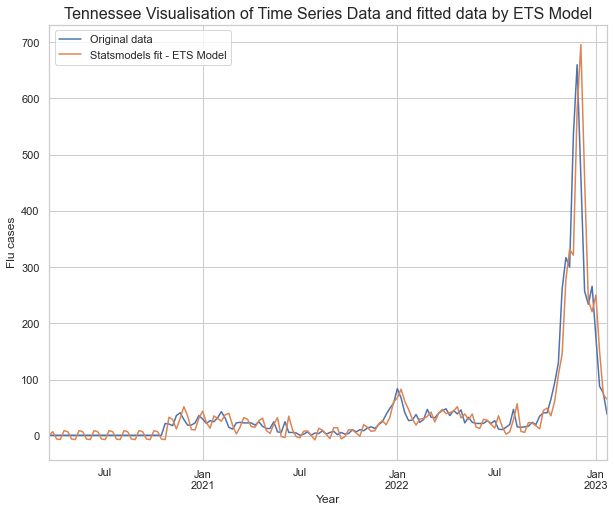

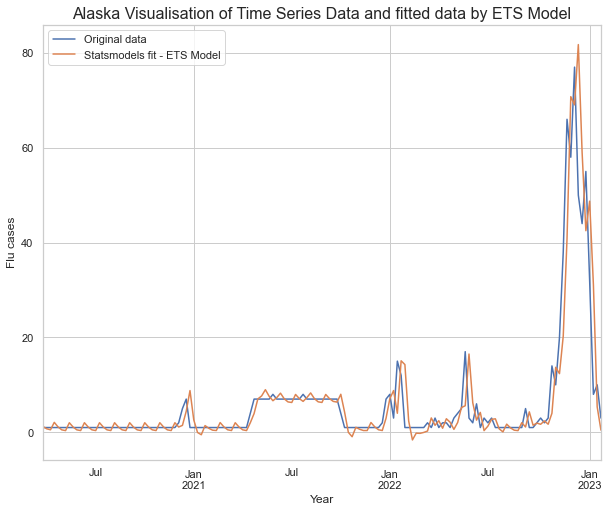

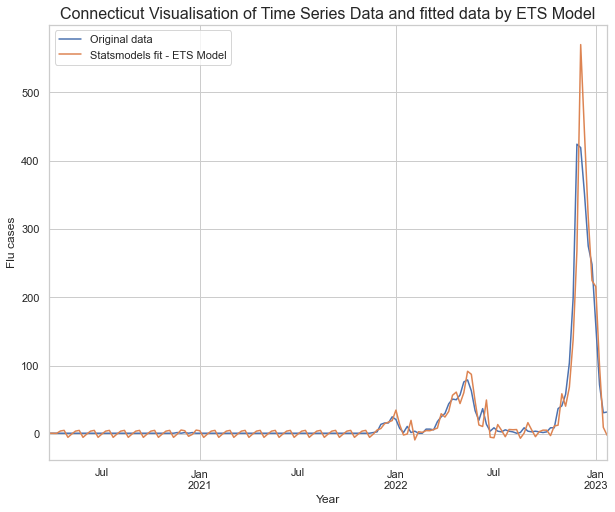

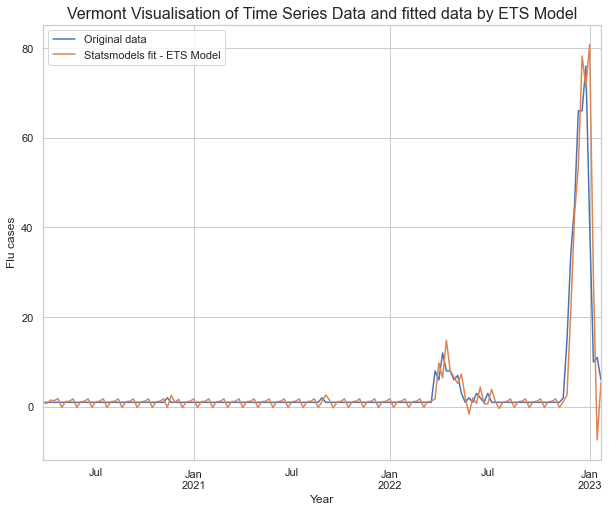

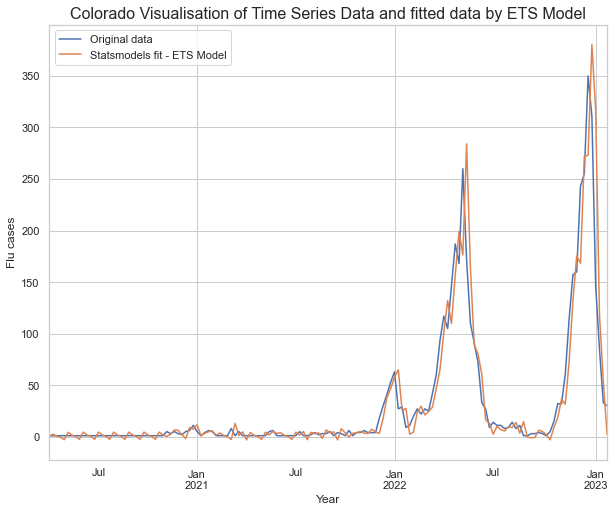

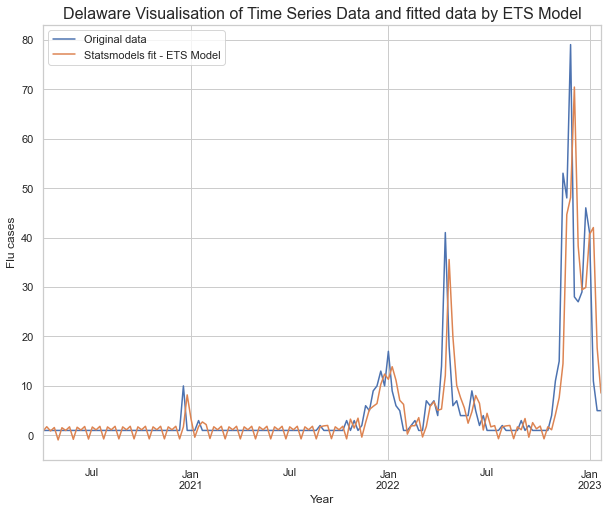

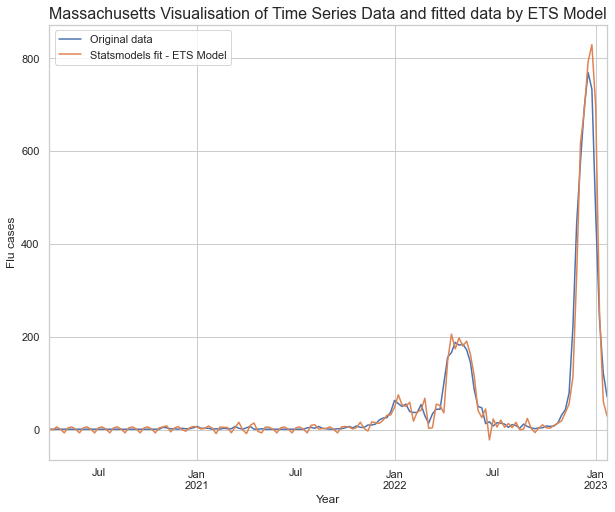

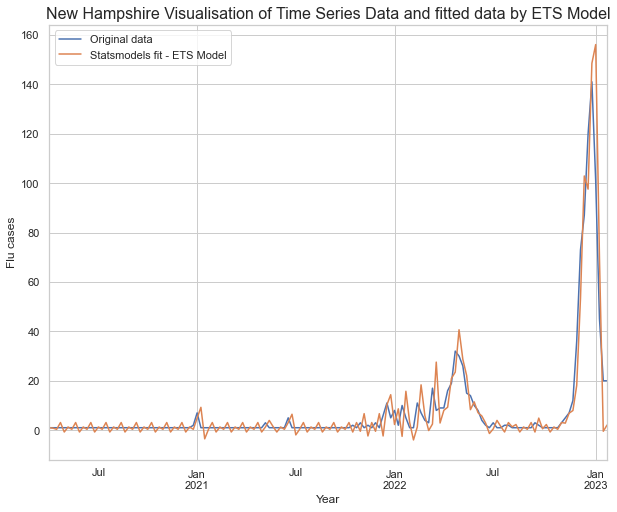

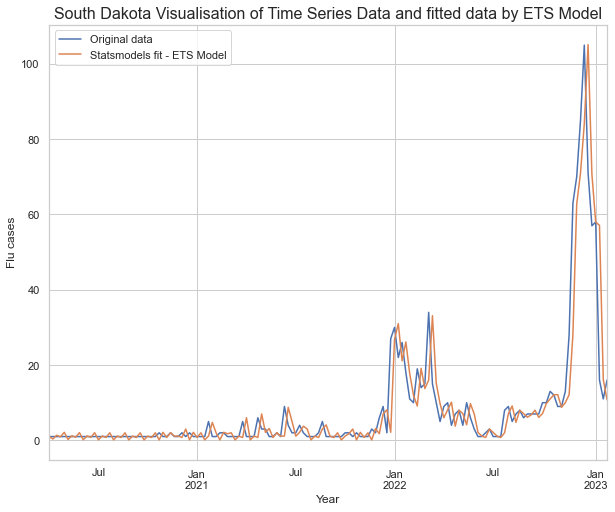

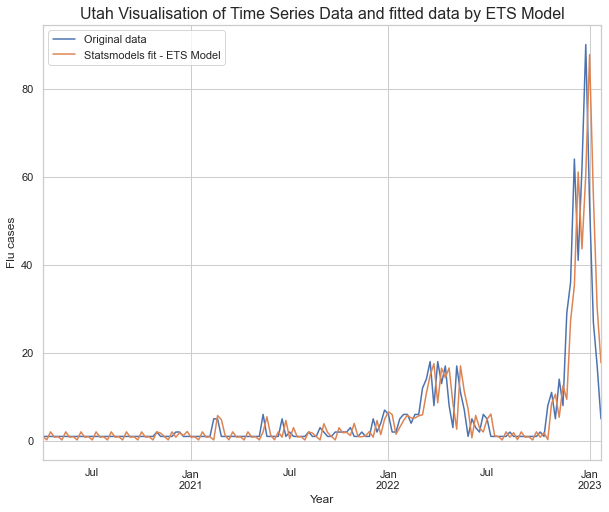

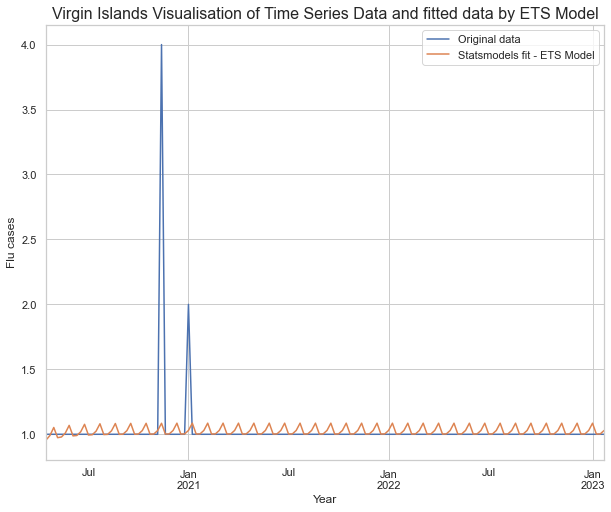

In [148]:
overall_pred = pd.DataFrame()
for state in df['location_name'].unique():
    if state not in ['US',"District of Columbia"]:
        overall_pred = overall_pred.append(ets_model(state, df))

In [150]:
truth_df = pd.read_csv('/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv')
# truth_df.index = pd.to_datetime(truth_df.index)
truth_df = truth_df[~truth_df['location'].isin(['US',"11"])]
truth_df.set_index('date', inplace=True)
truth_df.sort_values(by=['location'], inplace=True)

In [151]:
# Truth_2023_01_21 = np.array(truth_df[truth_df.index == '2023-01-21']['value'])
# Truth_2023_01_28 = np.array(truth_df[truth_df.index == '2023-01-28']['value'])
Truth_2023_02_04 = np.array(truth_df[truth_df.index == '2023-02-04']['value'])

In [153]:
# ETS_2023_01_21 = np.array(overall_pred[overall_pred.index == '2023-01-21']['mean'])
# ETS_2023_01_28 = np.array(overall_pred[overall_pred.index == '2023-01-28']['mean'])
ETS_2023_02_04 = np.array(overall_pred[overall_pred.index == '2023-02-04']['mean'])

In [158]:
overall_pred

,mean,pi_lower,pi_upper,location_name
2023-02-04,30.862977,-13.373430,75.099384,Alabama
2023-02-11,24.438179,-40.106926,88.983284,Alabama
2023-02-18,22.832501,-58.337238,104.002239,Alabama
2023-02-25,26.166854,-69.690598,122.024305,Alabama
2023-02-04,-3.823500,-14.645952,6.998951,Alaska
...,...,...,...,...
2023-02-25,-98.148267,-278.553286,82.256751,Wisconsin
2023-02-18,5.028588,-12.916864,22.974040,Wyoming
2023-02-04,4.442083,-6.558104,15.442269,Wyoming
2023-02-25,5.635432,-14.921162,26.192026,Wyoming


In [182]:
overall_pred = overall_pred.sort_values(by=['location_name'])
pred_1 = overall_pred[overall_pred.index == '2023-02-11'][['location_name','mean']]
pred_1.head()

,location_name,mean
2023-02-11,Alabama,24.438179
2023-02-11,Alaska,-8.780503
2023-02-11,Arizona,-68.892367
2023-02-11,Arkansas,-11.154469
2023-02-11,California,-56.278636


In [183]:
truth_1 = truth_df[truth_df.index == '2023-02-04'][['location_name','value']]
truth_1.head()

,location_name,value
date,,
2023-02-04,Alabama,34
2023-02-04,Alaska,11
2023-02-04,Arizona,56
2023-02-04,Arkansas,23
2023-02-04,California,119


In [ ]:
episolne


In [184]:
merged_1 = pd.merge(pred_1, truth_1, on='location_name')
merged_1['diff'] = merged_1['mean'] - merged_1['value']
merged_1.sort_values(by=['diff'], inplace=True)

In [185]:
merged_1

,location_name,mean,value,diff
43,Texas,48.120512,352,-303.879488
37,Pennsylvania,-99.754284,98,-197.754284
4,California,-56.278636,119,-175.278636
8,Florida,184.338659,330,-145.661341
2,Arizona,-68.892367,56,-124.892367
31,New York,-20.969004,101,-121.969004
21,Michigan,-19.171923,83,-102.171923
34,Ohio,-29.700412,65,-94.700412
24,Missouri,-21.664543,65,-86.664543
32,North Carolina,-24.401854,56,-80.401854
